In [1]:
# must go first 
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# basic wrangling 
import numpy as np
import pandas as pd

# eda tools 
import pivottablejs
import missingno as msno
import pandas_profiling

# interactive 
import ipywidgets as widgets

# more technical eda
import sklearn
import scipy

In [2]:
sys.path.append('../../scripts/')

In [3]:
from aqua_helper import time_slice, country_slice, time_series, simple_regions, subregion, variable_slice

In [4]:
# mpl_update = {'font.size':16,
#               'xtick.labelsize':14,
#               'ytick.labelsize':14,
#               'figure.figsize':[12.0,8.0],
#               'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
#               'axes.labelsize':16,
#               'axes.labelcolor':'#677385',
#               'axes.titlesize':20,
#               'lines.color':'#0055A7',
#               'lines.linewidth':3,
#               'text.color':'#677385'}
# mpl.rcParams.update(mpl_update)

http://www.fao.org/nr/water/aquastat/data/query/index.html

In [5]:
data = pd.read_csv('aquastat.csv.gzip', compression='gzip')
data.shape

(143280, 7)

In [6]:
simple_regions ={
    'World | Asia':'Asia',
    'Americas | Central America and Caribbean | Central America': 'North America',
    'Americas | Central America and Caribbean | Greater Antilles': 'North America',
    'Americas | Central America and Caribbean | Lesser Antilles and Bahamas': 'North America',
    'Americas | Northern America | Northern America': 'North America',
    'Americas | Northern America | Mexico': 'North America',
    'Americas | Southern America | Guyana':'South America',
    'Americas | Southern America | Andean':'South America',
    'Americas | Southern America | Brazil':'South America',
    'Americas | Southern America | Southern America':'South America', 
    'World | Africa':'Africa',
    'World | Europe':'Europe', 
    'World | Oceania':'Oceania'
}
# simplify regions
data.region = data.region.apply(lambda x: simple_regions[x])
data.shape

(143280, 7)

In [7]:

# remove exploitable fields and national rainfall index
data = data.loc[~data.variable.str.contains('exploitable'),:]
data = data.loc[~(data.variable=='national_rainfall_index')]
data.shape

(128952, 7)

Subset for cross-sectional analysis

In [8]:
recent = time_slice(data, '2013-2017')
recent

2013-2017,accounted_flow,accounted_flow_border_rivers,agg_to_gdp,arable_land,avg_annual_rain_depth,avg_annual_rain_vol,cultivated_area,dam_capacity_per_capita,dependency_ratio,flood_occurence,...,total_flow_border_rivers,total_pop,total_pop_access_drinking,total_renewable,total_renewable_groundwater,total_renewable_per_capita,total_renewable_surface,urban_pop,urban_pop_access_drinking,water_total_external_renewable
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,19.000,9.000,22.6000,7771.0,327.0,213.5000,7910.0,61.760,28.7200,3.7,...,33.400,32527.00,55.3,65.3300,10.650,2008.00,55.680,8547.00,78.2,18.180
Albania,3.300,0.000,22.0500,615.6,1485.0,42.6900,696.0,1391.000,10.9300,2.7,...,0.000,2897.00,95.1,30.2000,6.200,10425.00,26.350,1835.00,94.9,3.300
Algeria,0.390,0.000,13.0500,7469.0,89.0,212.0000,8439.0,209.300,3.5990,2.8,...,0.000,39667.00,83.6,11.6700,1.517,294.20,10.150,28739.00,84.3,0.420
Andorra,NaN,NaN,0.5239,2.8,NaN,0.4724,2.8,NaN,NaN,3.3,...,NaN,70.47,100.0,0.3156,NaN,4479.00,NaN,68.90,100.0,NaN
Angola,0.400,0.000,NaN,4900.0,1010.0,1259.0000,5190.0,377.500,0.2695,1.7,...,0.000,25022.00,49.0,148.4000,58.000,5931.00,145.400,10052.00,75.4,0.400
Antigua and Barbuda,0.000,0.000,2.3720,4.0,1030.0,0.4532,5.0,65.350,0.0000,3.6,...,0.000,91.82,97.9,0.0520,NaN,566.30,NaN,21.83,97.9,0.000
Argentina,584.200,67.940,8.3140,39200.0,591.0,1643.0000,40200.0,3031.000,66.6700,2.5,...,135.900,43417.00,99.1,876.2000,128.000,20181.00,860.200,38677.00,99.0,584.200
Armenia,0.910,0.910,19.3500,447.5,562.0,16.7100,505.2,NaN,11.7100,3.3,...,1.820,3018.00,100.0,7.7690,4.311,2574.00,4.858,1874.00,100.0,0.910
Australia,0.000,0.000,2.3840,46957.0,534.0,4134.0000,47307.0,3245.000,0.0000,2.7,...,0.000,23969.00,100.0,492.0000,72.000,20527.00,440.000,21393.00,100.0,0.000


# Exploring *population*

## Cross-section
For numerical data, look at: 

* *Location*: 均值，中位数，模式，四分位
* *Spread*: 标准差、方差、范围、间距范围
* *Shape*: 偏度、峰度

### Location and spread of the data

Are minimum/maximum values feasible? 

In [9]:
recent[['total_pop', 'urban_pop', 'rural_pop']].describe().astype(int)

2013-2017,total_pop,urban_pop,rural_pop
count,199,199,199
mean,36890,19849,17040
std,140720,69681,77461
min,0,0,-98
25%,1368,822,500
50%,7595,3967,2404
75%,25088,11656,10677
max,1407306,805387,891112


Rural population is negative... what does that mean? 

In [10]:
recent.sort_values('rural_pop')[['total_pop','urban_pop','rural_pop']].head()

2013-2017,total_pop,urban_pop,rural_pop
country,,,
Qatar,2235.00,2333.00,-98.00
Singapore,5604.00,5619.00,-15.00
Monaco,37.73,38.32,-0.59
Holy See,0.80,0.80,0.00
Nauru,10.22,10.12,0.10


`Rural population = Total population - urban population`

In [13]:
def time_series1(df, country, variable):
    # Only take data for country/variable combo
    series = df[(df.country == country) & (df.variable == variable)]

    # Drop years with no data
    series = series.dropna()[['year_measured', 'value']]

    # Change years to int and set as index
    series.year_measured = series.year_measured.astype(int)
    series.set_index('year_measured', inplace=True)
    series.columns = [variable]
    return series
time_series1(data, 'Qatar', 'total_pop')

,total_pop
year_measured,
1962,56.19
1967,86.16
1972,130.40
1977,182.40
1982,277.20
1987,423.30
1992,489.70
1997,528.20
2002,634.40


In [14]:
time_series(data, 'Qatar', 'total_pop').join(time_series(data, 'Qatar', 'urban_pop')).join(time_series(data, 'Qatar', 'rural_pop'))

,total_pop,urban_pop,rural_pop
year_measured,,,
1962,56.19,48.39,7.80
1967,86.16,75.48,10.68
1972,130.40,115.60,14.80
1977,182.40,162.40,20.00
1982,277.20,248.60,28.60
1987,423.30,385.40,37.90
1992,489.70,459.10,30.60
1997,528.20,506.50,21.70
2002,634.40,608.90,25.50


We should also start suspecting that the data is skewed:
* 50% quartile much closer to 25% or 75% in value
* Large difference between mean and 50% 

### Shape of the data
* 数据分布是倾斜的吗？
* 有异常值吗？它们可行吗？ 
* 有不连续的吗? 

In [15]:
recent[['total_pop', 'urban_pop', 'rural_pop']].describe().astype(int)

2013-2017,total_pop,urban_pop,rural_pop
count,199,199,199
mean,36890,19849,17040
std,140720,69681,77461
min,0,0,-98
25%,1368,822,500
50%,7595,3967,2404
75%,25088,11656,10677
max,1407306,805387,891112


是的，看起来人口是倾斜的。让我们尝试计算偏度和峰度和绘制直方图显示。

<img src="figures/f1.png" alt="FAO" width="400" align="right">
<img src="figures/f2.png" alt="FAO" width="290" align="right">
### [Skewness and kurtosis](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)

左偏：均值<中位数

*Skewness:* measure of lack of symmetry. 

*Kurtosis:* measure of whether the data are heavily tailed relative to the normal distribution. 

In [16]:
recent[['total_pop', 'urban_pop', 'rural_pop']].apply(scipy.stats.skew)

2013-2017
total_pop    8.519379
urban_pop    8.545690
rural_pop    9.490029
dtype: float64

正态分布的偏度应为零。负偏度表示偏左，正偏表示右偏。

In [17]:
recent[['total_pop', 'urban_pop', 'rural_pop']].apply(scipy.stats.kurtosis)

2013-2017
total_pop    76.923725
urban_pop    85.499659
rural_pop    95.838930
dtype: float64

峰度也是一个正态分布和零只能是积极的。我们肯定有一些异常值！

### The trusty histogram

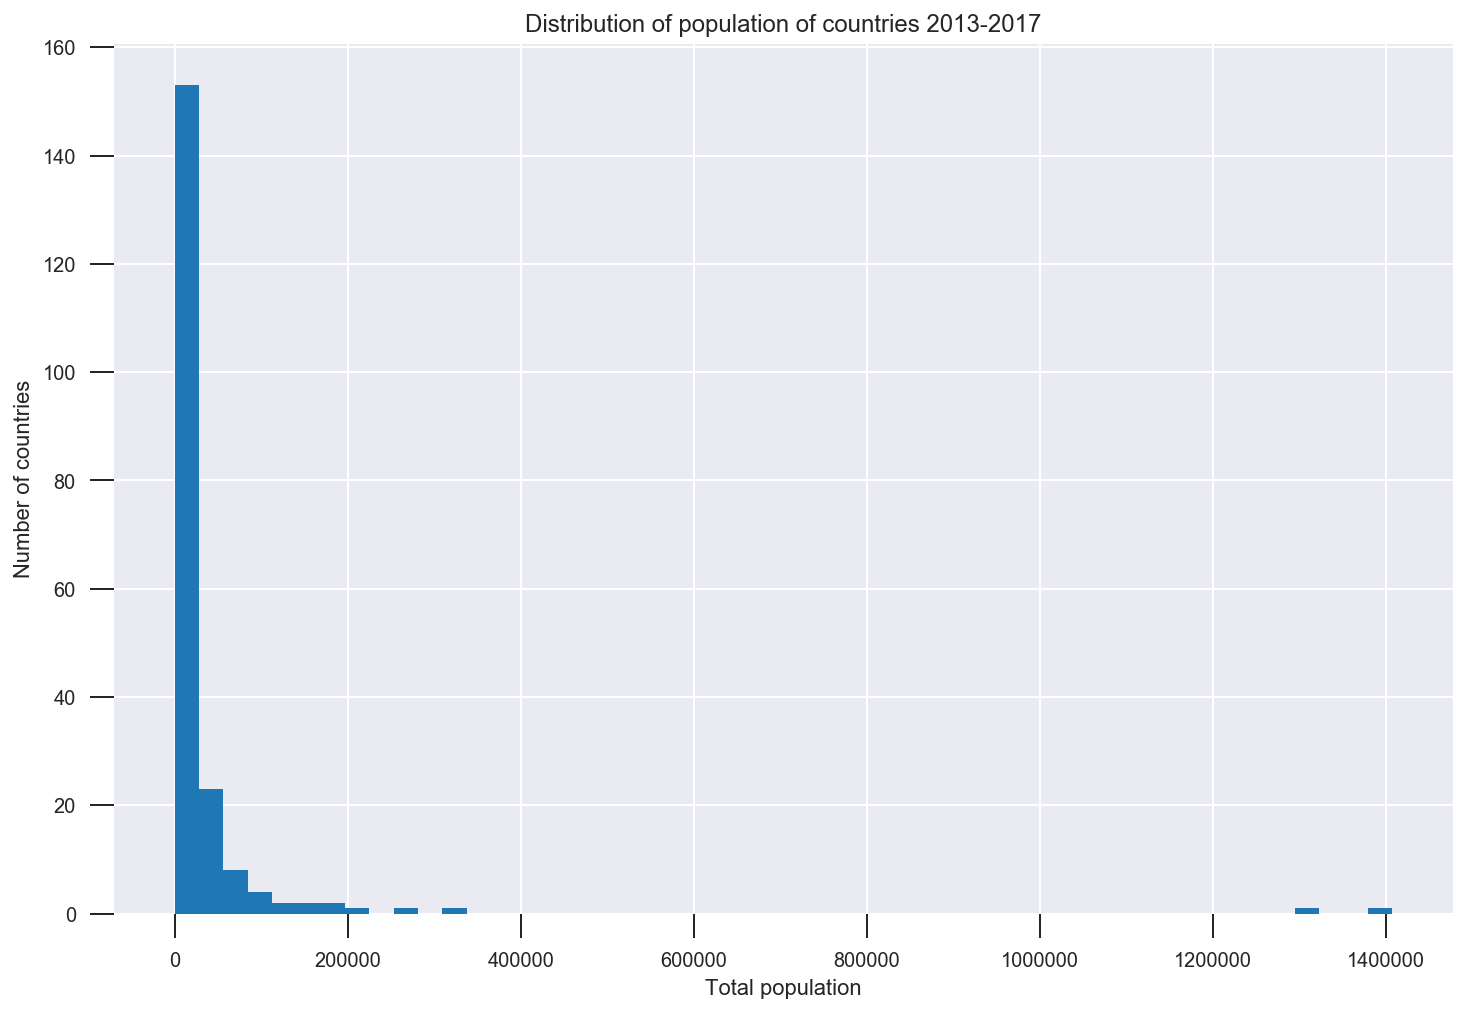

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(recent.total_pop.values, bins=50);
ax.set_xlabel('Total population');
ax.set_ylabel('Number of countries');
ax.set_title('Distribution of population of countries 2013-2017');

Let's functionalize this so we can use it again.

Yup, definitely skewed. Why is this a problem?
* Many models assume a normal (bell-like) curve
* It is difficult to differentiate observations when skewed (~150/199 look all the same!) 



解决方法是什么？通常，使用LOG转换将使变量更为正常。

### Log transform


<img src="figures/f3.png" alt="FAO" width="590" >
对数变换是数据变换的一种常用方式，数据变换的目的在于使数据的呈现方式接近我们所希望的前提假设，从而更好的进行统计推断。

<img src="figures/f4.png" alt="FAO" width="590" >
左边是正常数据，可以看到随着时间推进，电力生产也变得方差越来越大，即越来越不稳定。
这种情况下常有的分析假设经常就不会满足（误差服从独立同分布的正态分布，时间序列要求平稳）。

理论上，我们将这类问题抽象成这种模型，即分布的标准差与其均值线性相关

In [19]:
recent[['total_pop']].apply(np.log).apply(scipy.stats.skew)
# recent[['total_pop']].apply(np.log).apply(scipy.stats.skewtest)

2013-2017
total_pop   -0.899063
dtype: float64

它确实减少了偏斜，但并没有使它消失。峰度如何？

In [20]:
recent[['total_pop']].apply(np.log).apply(scipy.stats.kurtosis)
# recent[['total_pop']].apply(np.log).apply(scipy.stats.kurtosistest)

2013-2017
total_pop    1.086877
dtype: float64

再次，它减少了，但并没有摆脱峰度。

In [21]:
def plot_hist(df, variable, bins=20, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):

    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
    if logx:
        if df[variable].min() <=0:
            df[variable] = df[variable] - df[variable].min() + 1
            print('Warning: data <=0 exists, data transformed by %0.2g before plotting' % (- df[variable].min() + 1))
        
        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        print(bins)
        ax.set_xscale("log")

    ax.hist(df[variable].dropna().values, bins=bins);
    
    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);
    
    return ax

[8.00000000e-01 1.45650091e+00 2.65174362e+00 4.82783375e+00
 8.78968030e+00 1.60027217e+01 2.91349733e+01 5.30438939e+01
 9.65730997e+01 1.75823509e+02 3.20108876e+02 5.82798587e+02
 1.06105834e+03 1.93179055e+03 3.51706836e+03 6.40326657e+03
 1.16579545e+04 2.12247766e+04 3.86423830e+04 7.03533325e+04
 1.28087116e+05 2.33198751e+05 4.24567741e+05 7.72979126e+05
 1.40730600e+06]


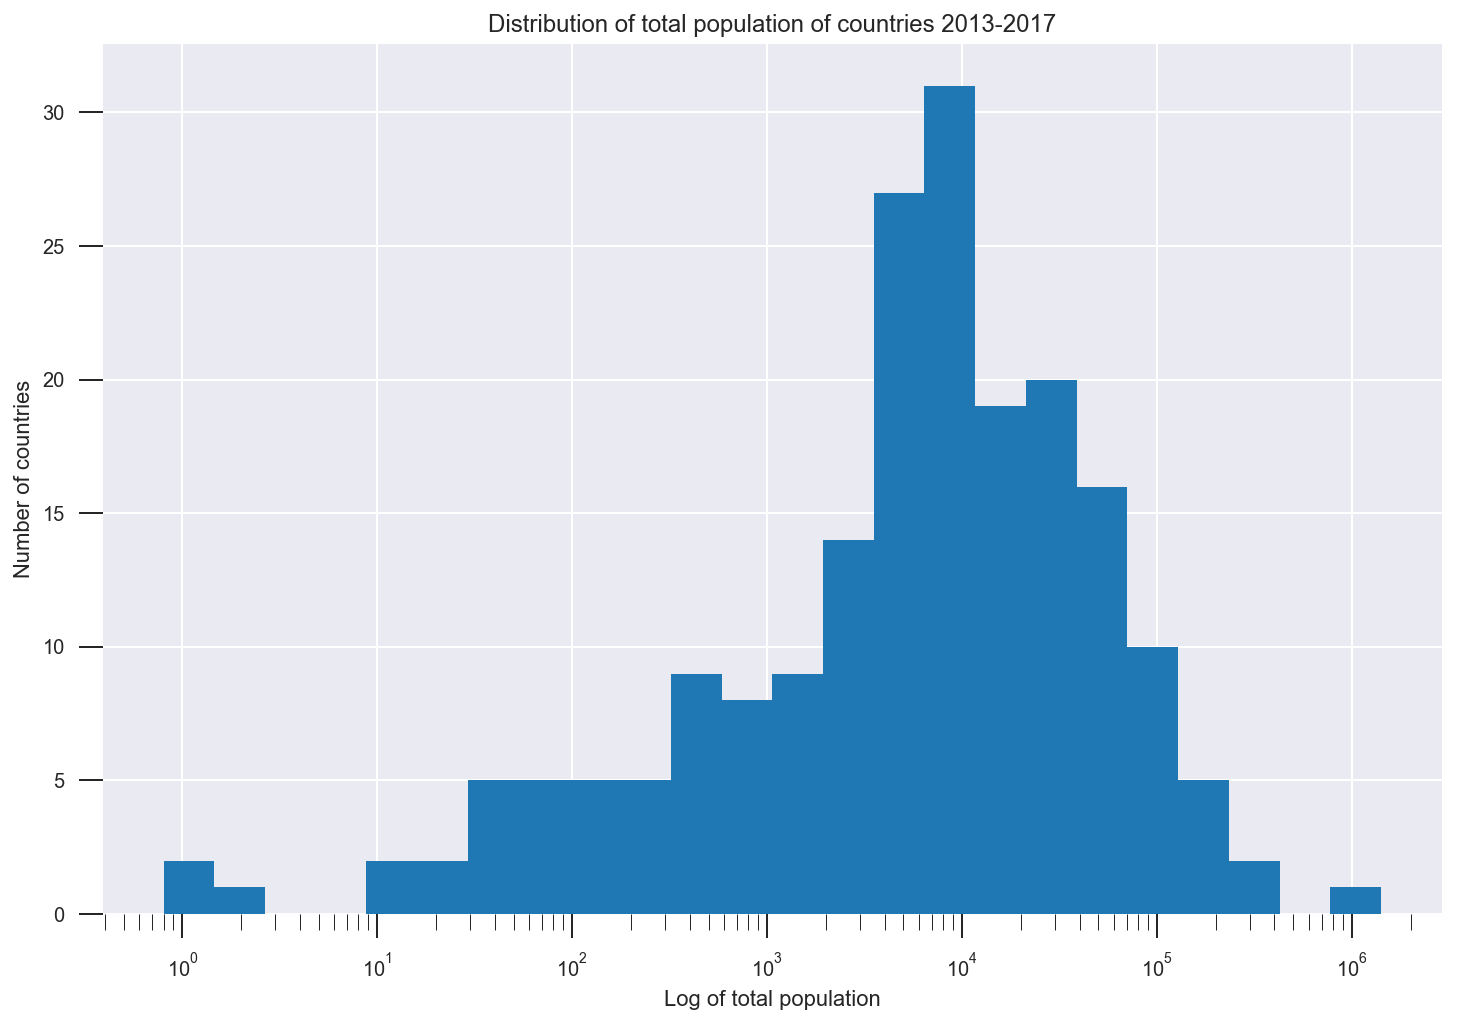

In [22]:
plot_hist(recent, 'total_pop', bins=25, logx=True, 
          xlabel='Log of total population', ylabel='Number of countries',
          title='Distribution of total population of countries 2013-2017');#logx=True

### Normalization

In [27]:
recent['population_density'] = recent.total_pop.divide(recent.total_area)#人口面积/人口面积==密度
print(recent.head())

2013-2017    accounted_flow  accounted_flow_border_rivers  agg_to_gdp  \
country                                                                 
Afghanistan           19.00                           9.0     22.6000   
Albania                3.30                           0.0     22.0500   
Algeria                0.39                           0.0     13.0500   
Andorra                 NaN                           NaN      0.5239   
Angola                 0.40                           0.0         NaN   

2013-2017    arable_land  avg_annual_rain_depth  avg_annual_rain_vol  \
country                                                                
Afghanistan       7771.0                  327.0             213.5000   
Albania            615.6                 1485.0              42.6900   
Algeria           7469.0                   89.0             212.0000   
Andorra              2.8                    NaN               0.4724   
Angola            4900.0                 1010.0         

## Over time

### One country

Check a sample we have familiarity with. 
* Are the units what we think they are? 
* Does this behavior correspond with our pre-existing knowledge? 

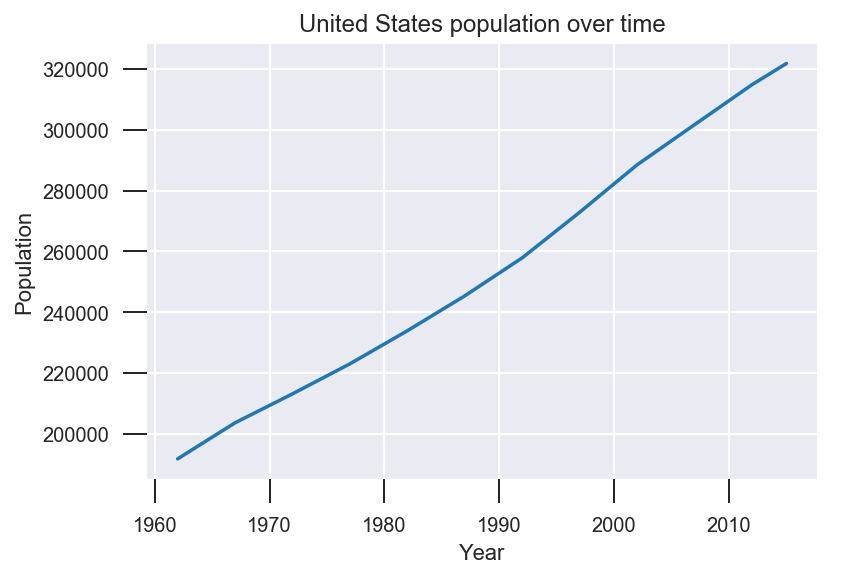

In [28]:
plt.plot(time_series(data, 'United States of America', 'total_pop'));
plt.xlabel('Year');
plt.ylabel('Population');
plt.title('United States population over time');


### One region 

['Saint Kitts and Nevis', 'Antigua and Barbuda', 'Dominica', 'Saint Vincent and the Grenadines', 'Saint Lucia', 'Grenada', 'Belize', 'Bahamas', 'Barbados', 'Trinidad and Tobago', 'Panama', 'Costa Rica', 'Jamaica', 'Nicaragua', 'Honduras', 'El Salvador', 'Dominican Republic', 'Haiti', 'Guatemala', 'Cuba', 'Canada', 'Mexico', 'United States of America']


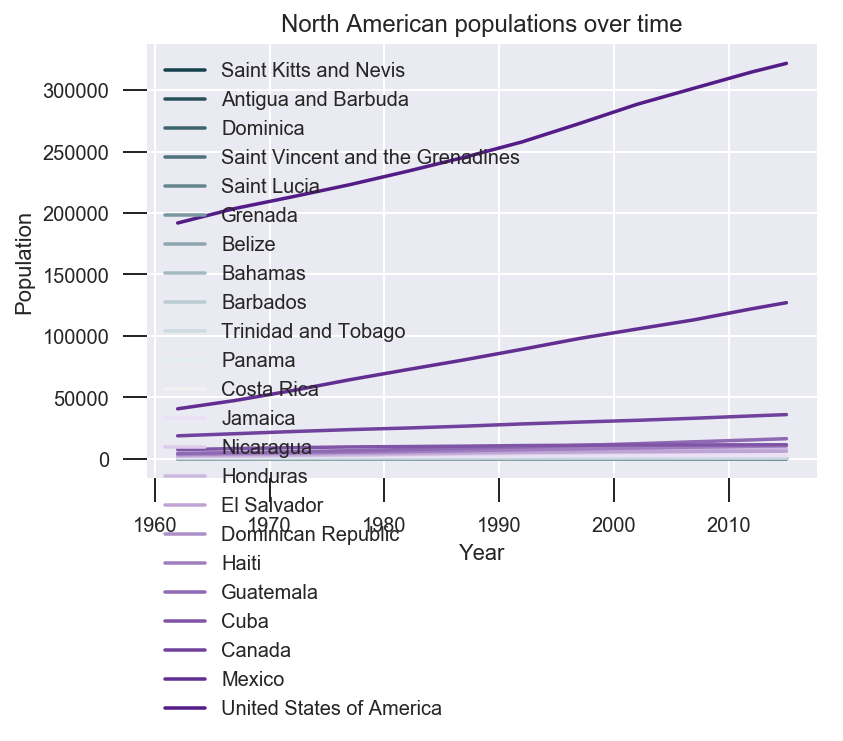

In [32]:
with sns.color_palette(sns.diverging_palette(220, 280, s=85, l=25, n=23)):
    north_america = time_slice(subregion(data, 'North America'), '1958-1962').sort_values('total_pop').index.tolist()
    print(north_america)
    for country in north_america:
        plt.plot(time_series(data, country, 'total_pop'), label=country);
        plt.xlabel('Year');
        plt.ylabel('Population');
        plt.title('North American populations over time');
    plt.legend(loc=2,prop={'size':10});


这除了北美洲是最大的国家之外，什么也没有告诉我们。我们想了解每个国家的人口是如何随着时间的推移而变化的，主要是参照自身的变化。

我们应该通过什么标准化？我们可以选择一个国家的最小、平均、中位数、最大值…或任何其他位置

让我们选择最小值，这样我们就能看到每个国家在起始人口上的增长。

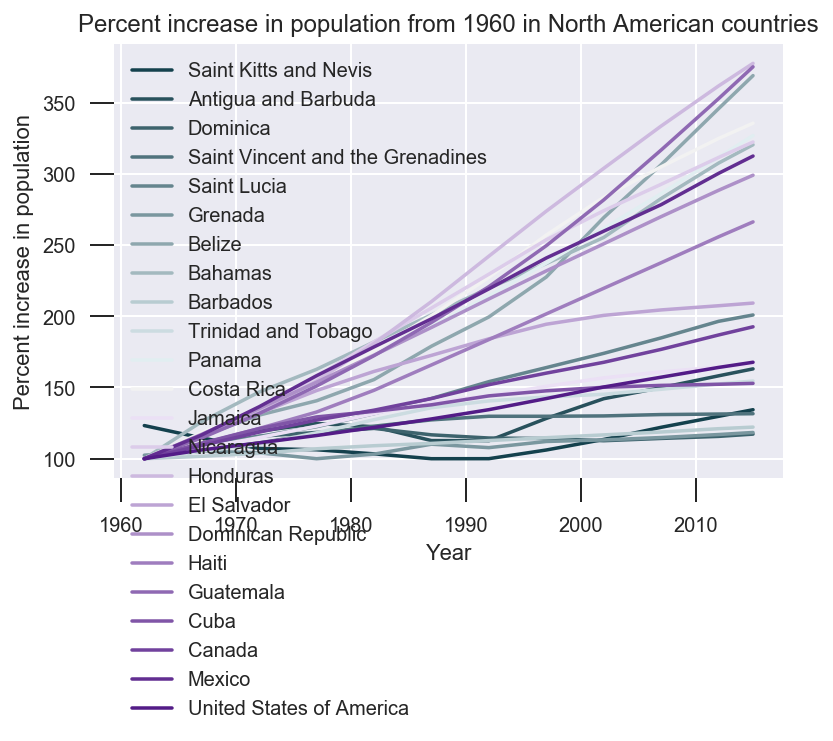

In [33]:
with sns.color_palette(sns.diverging_palette(220, 280, s=85, l=25, n=23)):
    for country in north_america:
        ts = time_series(data, country, 'total_pop')
        ts['norm_pop'] = ts.total_pop/ts.total_pop.min()*100
        plt.plot(ts['norm_pop'], label=country);
        plt.xlabel('Year');
        plt.ylabel('Percent increase in population');
        plt.title('Percent increase in population from 1960 in North American countries');
    plt.legend(loc=2,prop={'size':10});


There are too many lines here!  We should really only have 3-4 lines on a plot to be able to spot patterns. What we can see, however, is that *generally*, larger countries grow faster thatn smaller, with two main exceptions. But, we can't figure out which countries those are. Another option is a heatmap. 

In [38]:
north_america_pop = variable_slice(subregion(data, 'North America'), 'total_pop')
north_america_norm_pop = north_america_pop.div(north_america_pop.min(axis=1), axis=0)*100
print(north_america_norm_pop)
north_america_norm_pop = north_america_norm_pop.loc[north_america]

time_period                        1958-1962   1963-1967   1968-1972  \
country                                                                
Antigua and Barbuda               100.000000  110.104777  119.339371   
Bahamas                           100.000000  126.011561  146.820809   
Barbados                          100.000000  101.719690  103.783319   
Belize                            100.000000  115.720300  130.608892   
Canada                            100.000000  109.265809  118.660236   
Costa Rica                        100.000000  118.283322  135.868807   
Cuba                              100.000000  110.926174  121.140940   
Dominica                          100.000000  109.196515  115.747015   
Dominican Republic                100.000000  117.154218  135.188867   
El Salvador                       100.000000  115.573770  131.898907   
Grenada                           102.472558  105.288835  104.157889   
Guatemala                         100.000000  114.597200  131.69

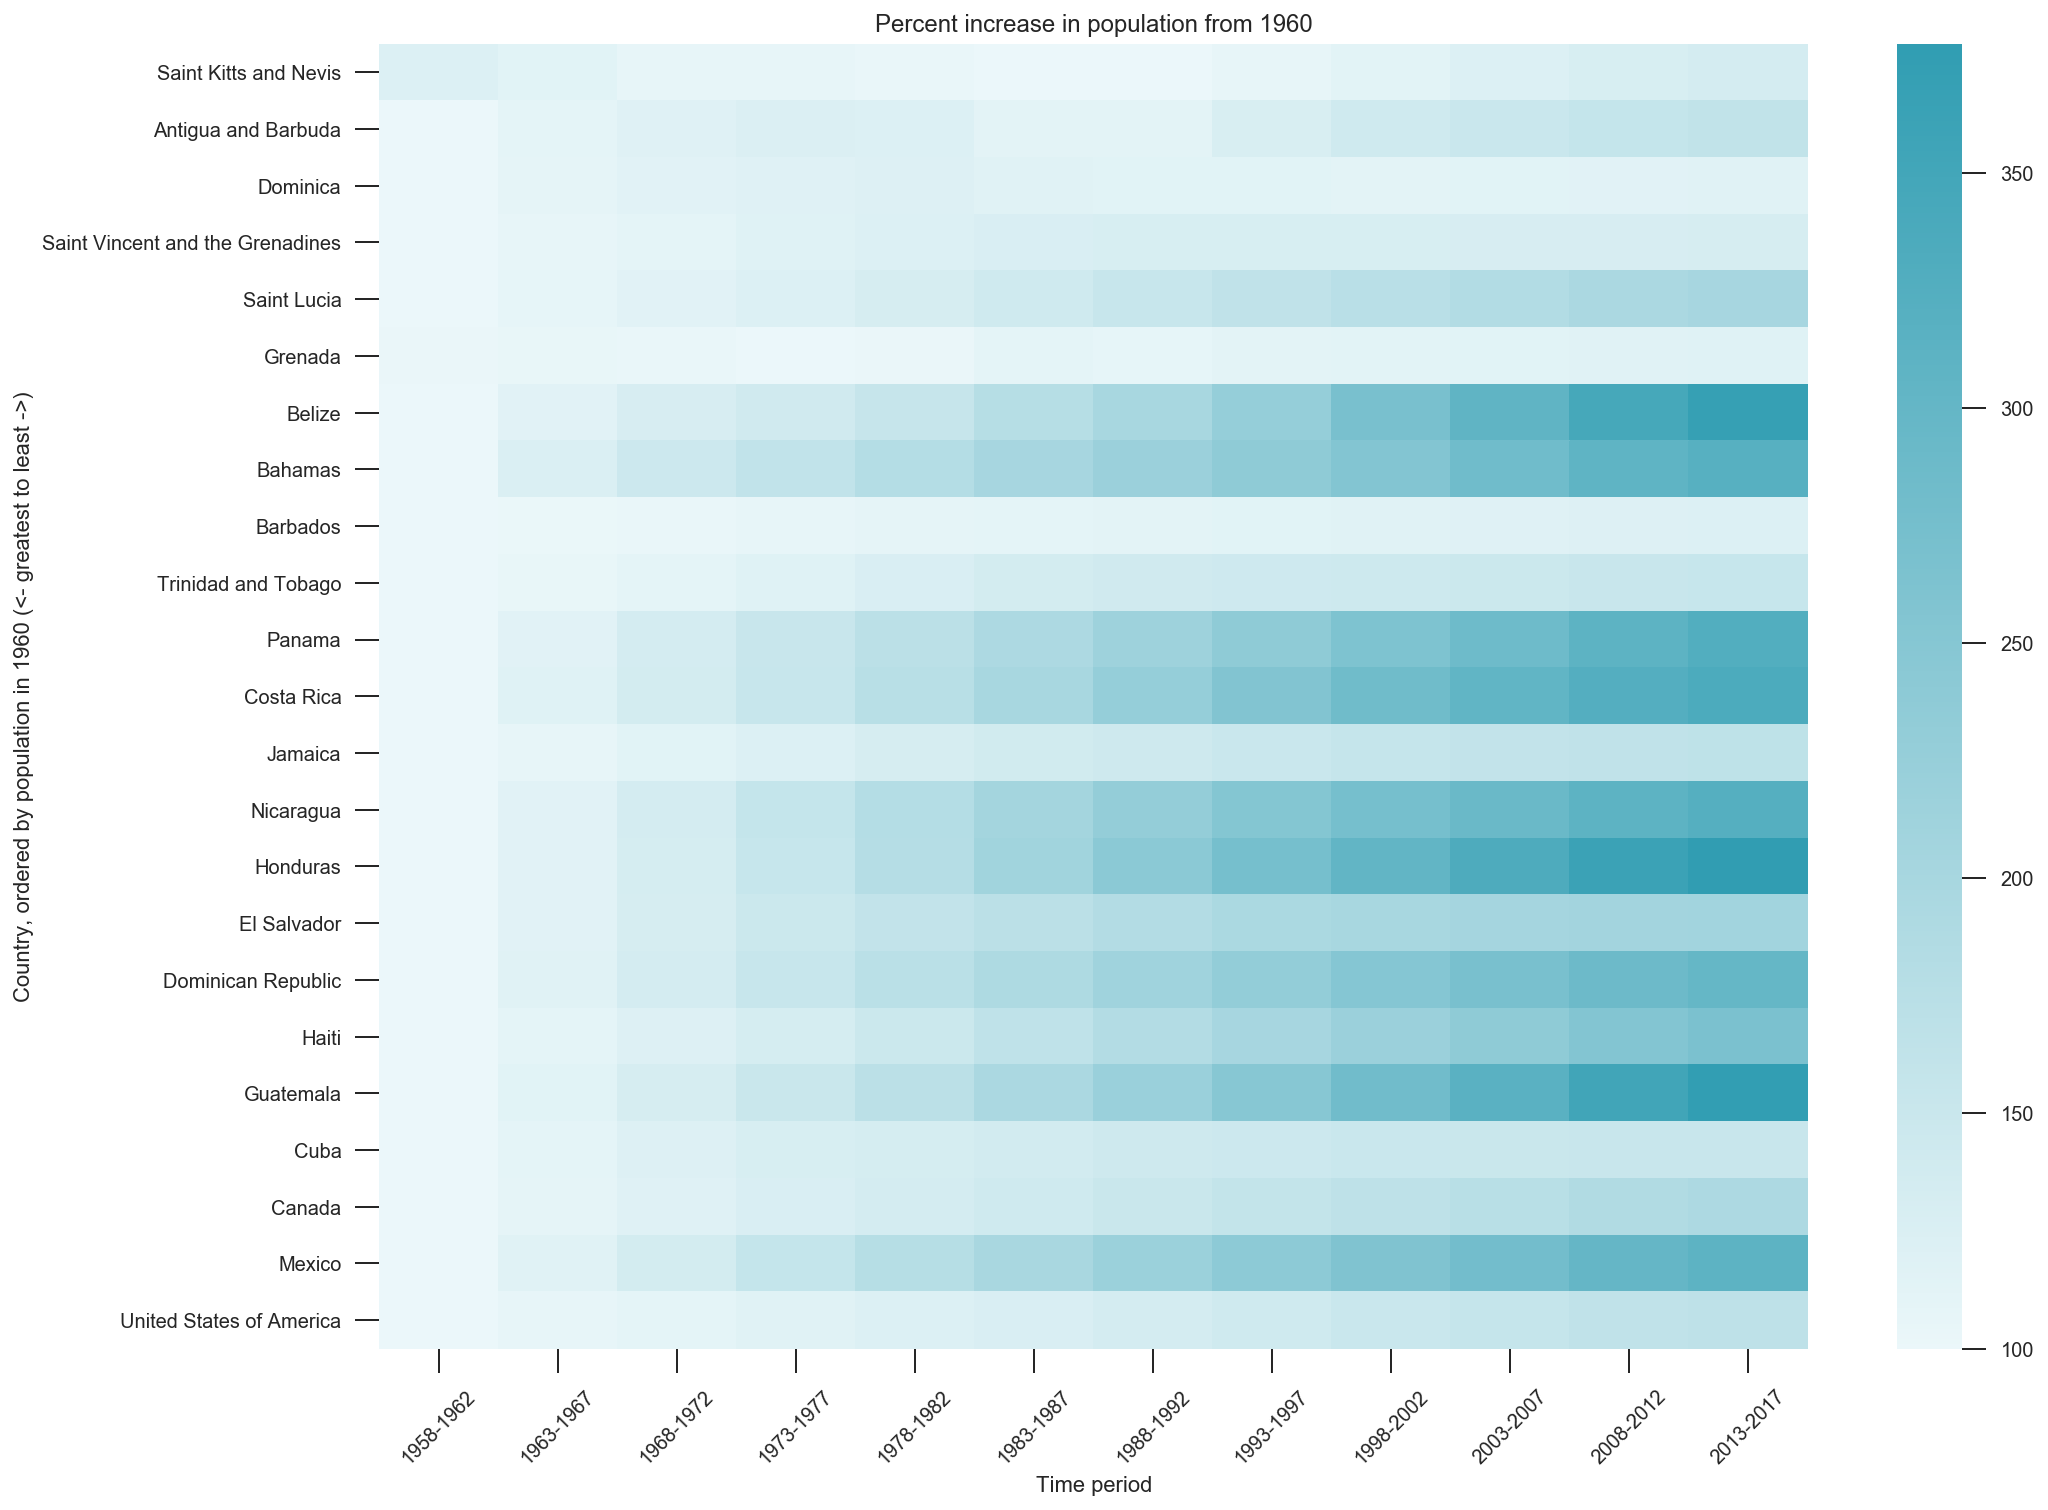

In [37]:
fig, ax = plt.subplots(figsize=(16, 12));
sns.heatmap(north_america_norm_pop, ax=ax, cmap=sns.light_palette((214, 90, 60), input="husl", as_cmap=True));
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Country, ordered by population in 1960 (<- greatest to least ->)');
plt.title('Percent increase in population from 1960');


## Exploring *total renewable water resources*

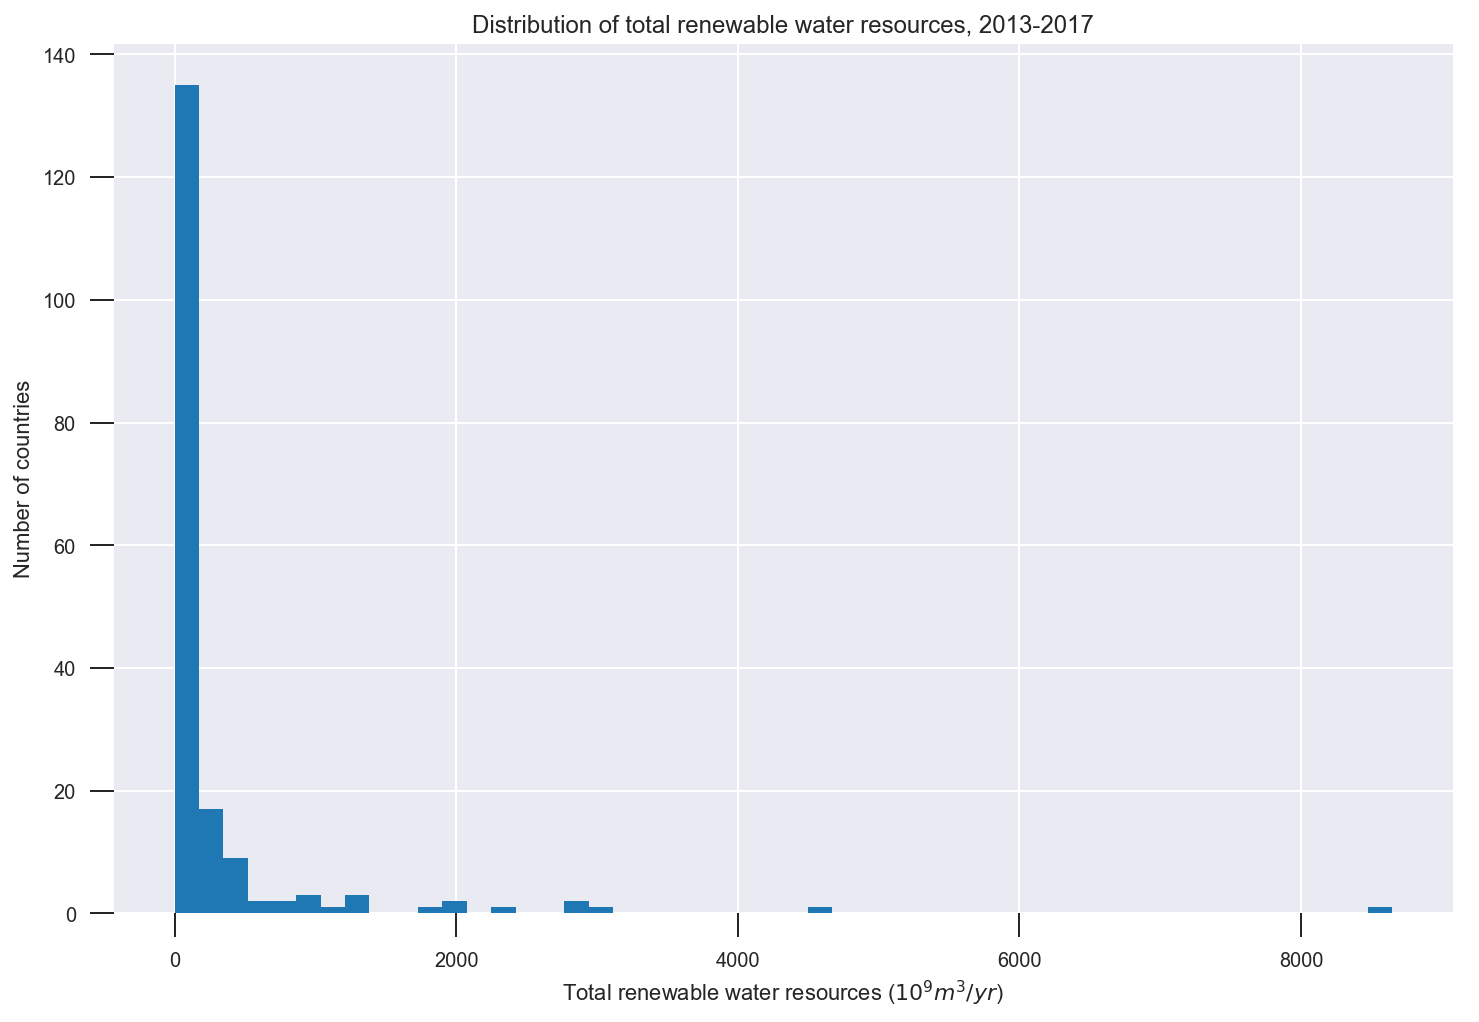

In [39]:
plot_hist(recent, 'total_renewable', bins=50, 
          xlabel='Total renewable water resources ($10^9 m^3/yr$)',
          ylabel='Number of countries', 
          title='Distribution of total renewable water resources, 2013-2017');

[2.00000000e-02 2.60643588e-02 3.39675401e-02 4.42671076e-02
 5.76896889e-02 7.51822376e-02 9.79788409e-02 1.27687783e-01
 1.66405010e-01 2.16861995e-01 2.82618442e-01 3.68313425e-01
 4.79992663e-01 6.25535050e-01 8.15208500e-01 1.06239434e+00
 1.38453137e+00 1.80434612e+00 2.35145624e+00 3.06445996e+00
 3.99365920e+00 5.20460832e+00 6.78273894e+00 8.83938707e+00
 1.15196478e+01 1.50126117e+01 1.95647049e+01 2.54970745e+01
 3.32282449e+01 4.33036450e+01 5.64340871e+01 7.35459148e+01
 9.58463556e+01 1.24908690e+02 1.62783246e+02 2.12142047e+02
 2.76467322e+02 3.60297174e+02 4.69545741e+02 6.11920434e+02
 7.97465689e+02 1.03927159e+03 1.35439739e+03 1.76507497e+03
 2.30027737e+03 2.99776274e+03 3.90673819e+03 5.09133130e+03
 6.63511430e+03 8.64700000e+03]


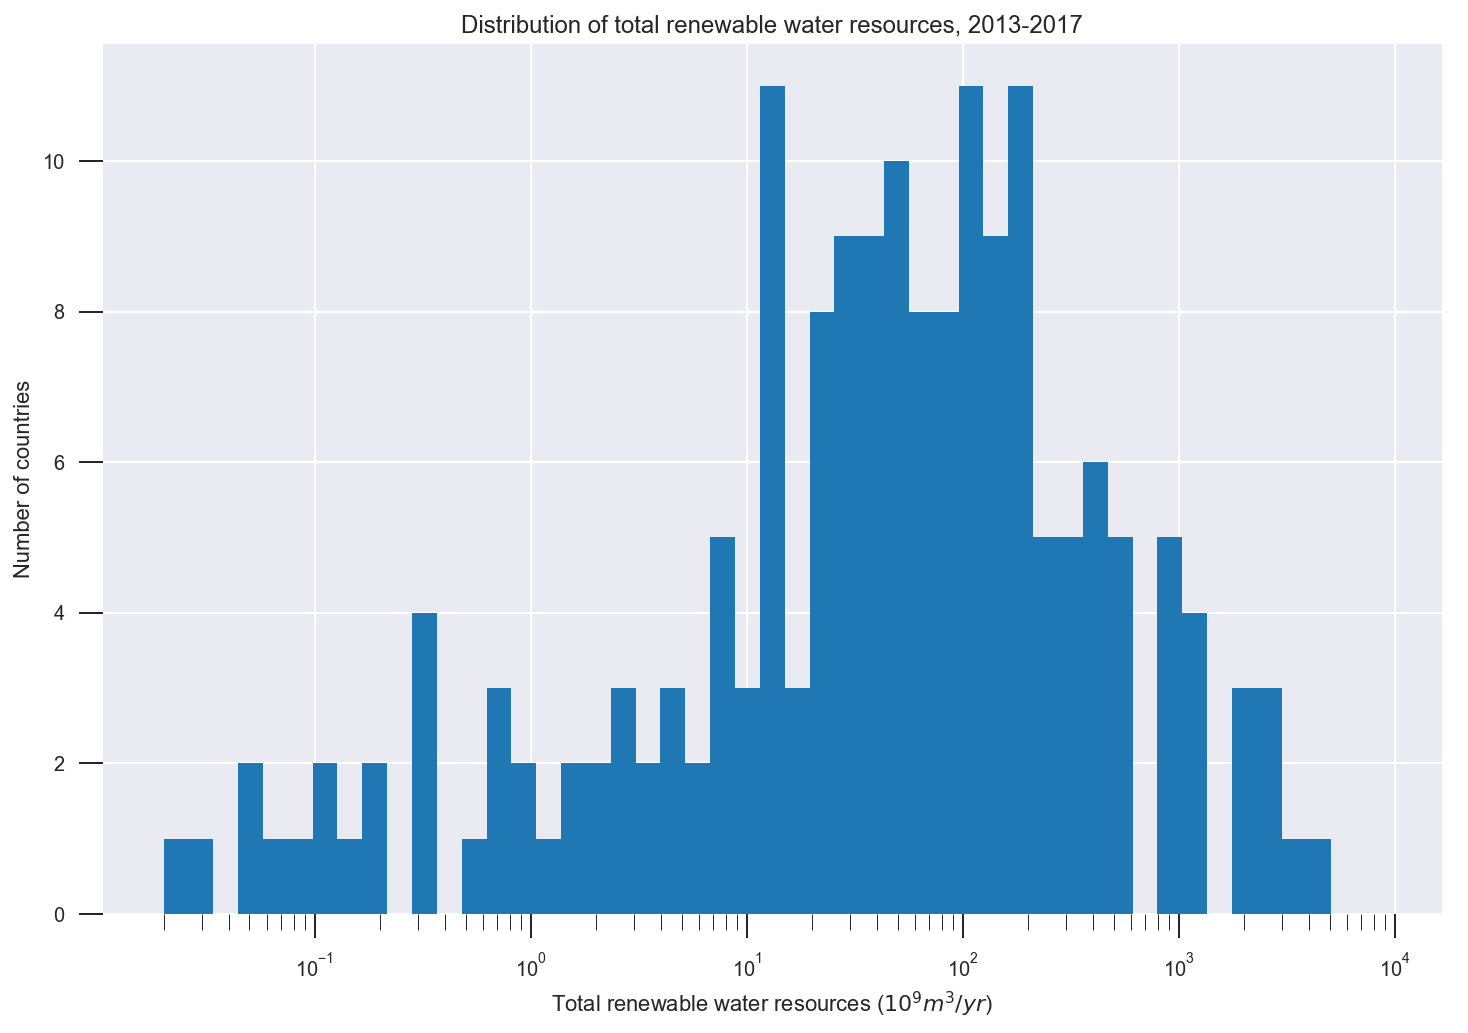

In [40]:
plot_hist(recent, 'total_renewable', bins=50, 
          xlabel='Total renewable water resources ($10^9 m^3/yr$)',
          ylabel='Number of countries', logx=True,
          title='Distribution of total renewable water resources, 2013-2017');

In [42]:
north_america_renew = variable_slice(subregion(data, 'North America'), 'total_renewable')

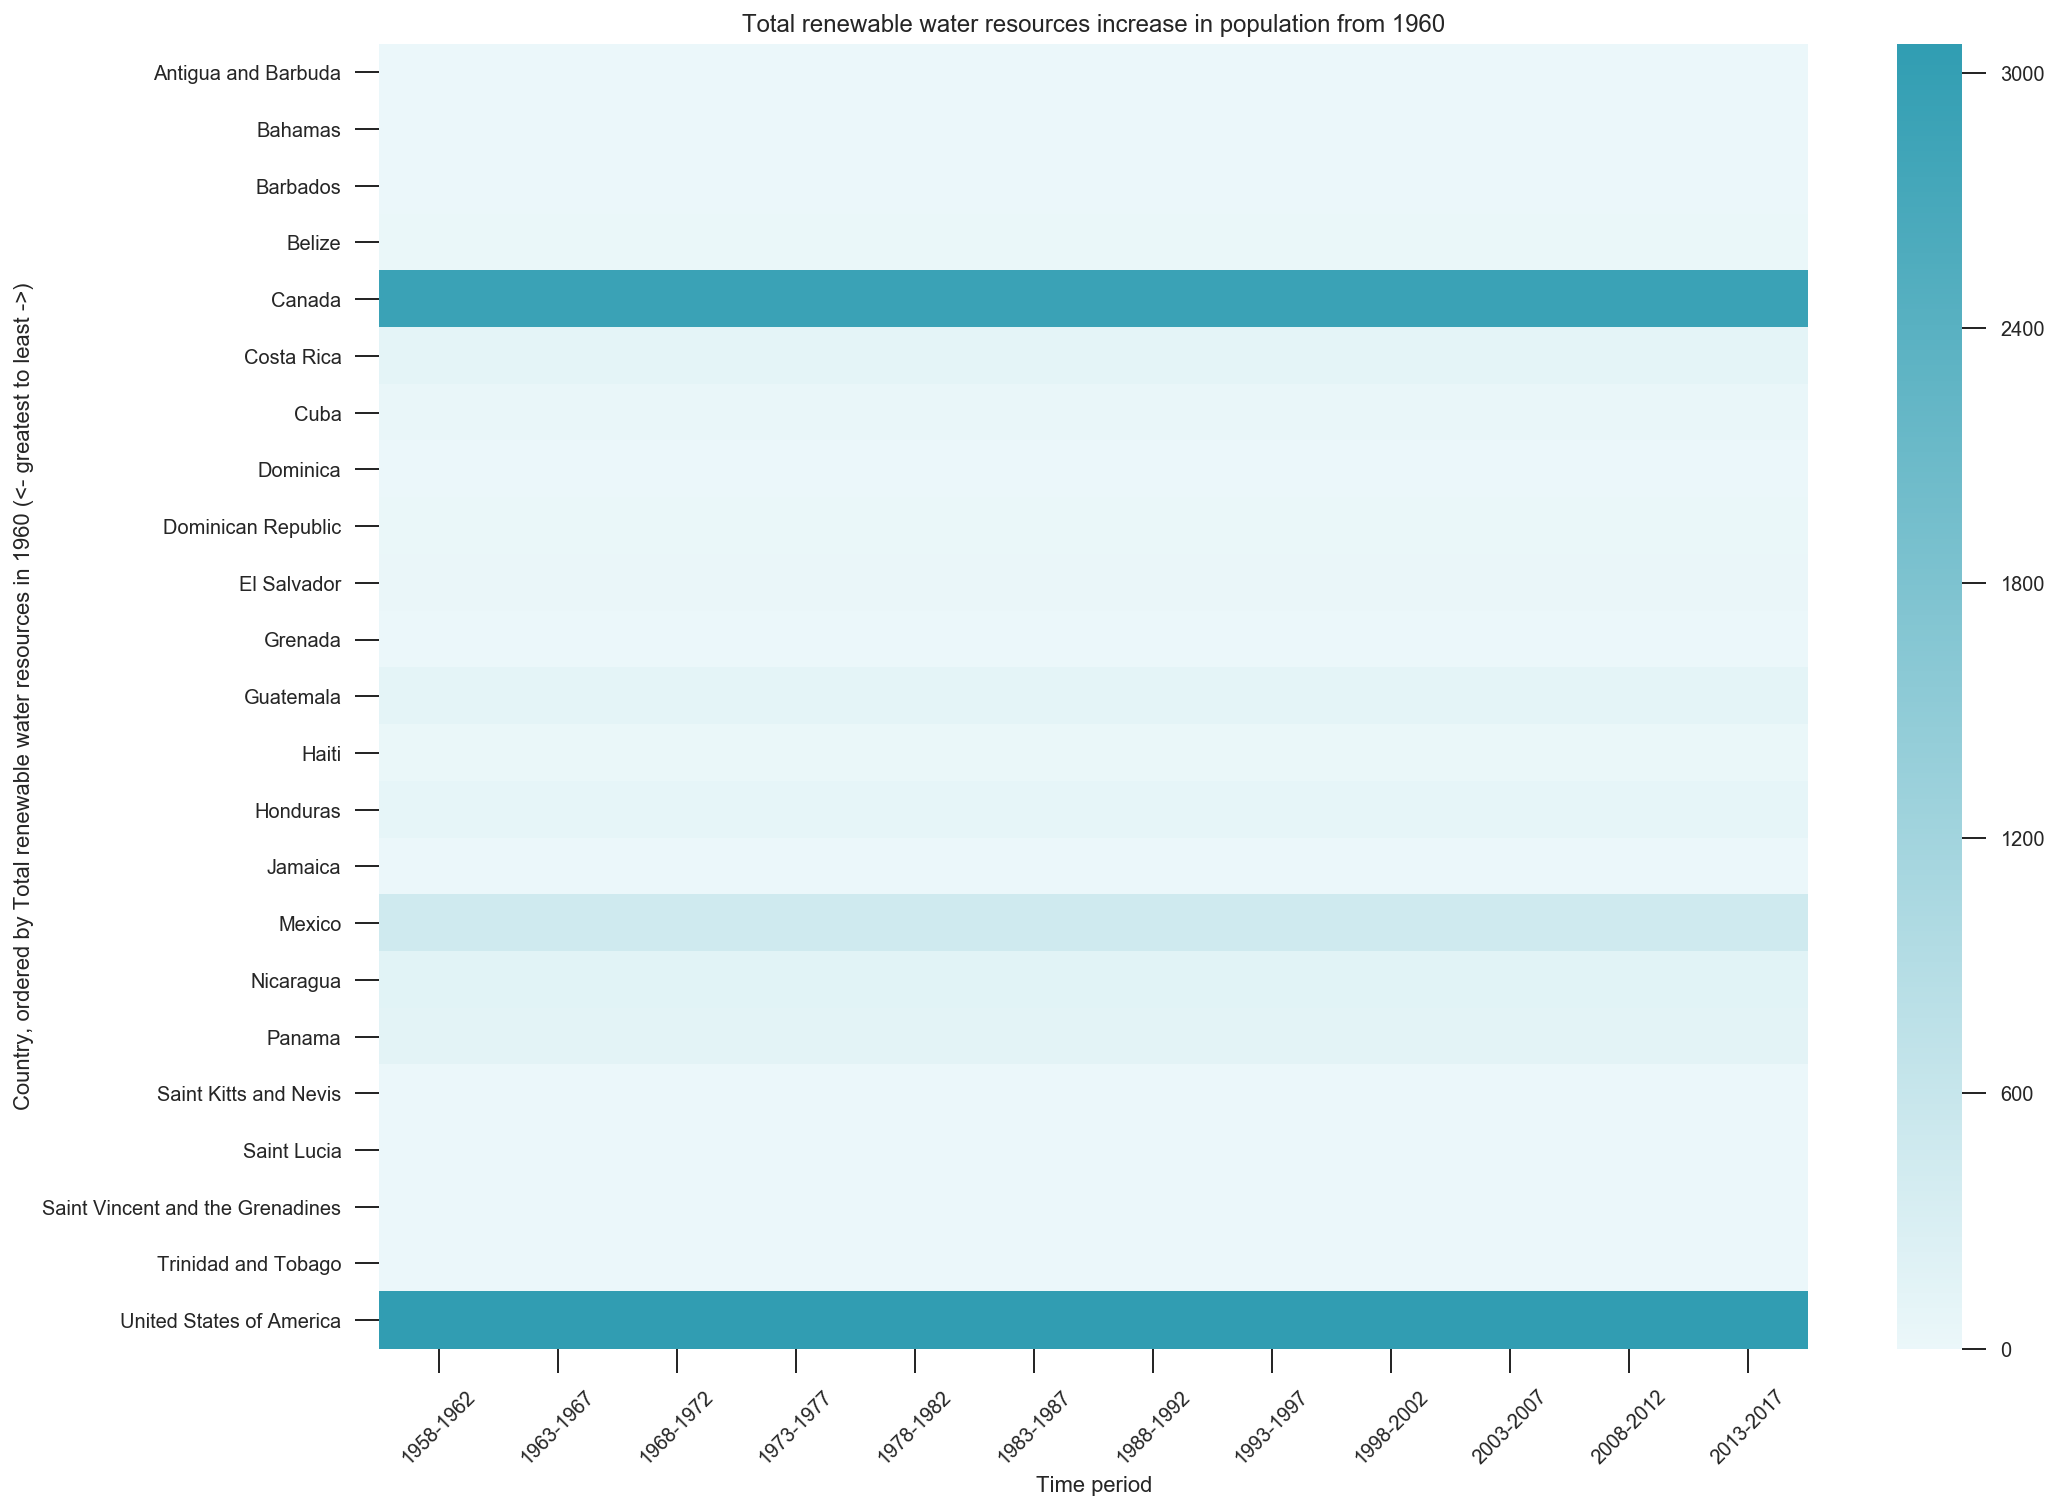

In [43]:
fig, ax = plt.subplots(figsize=(16, 12));
sns.heatmap(north_america_renew, ax=ax, cmap=sns.light_palette((214, 90, 60), input="husl", as_cmap=True));
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Country, ordered by Total renewable water resources in 1960 (<- greatest to least ->)');
plt.title('Total renewable water resources increase in population from 1960');


## Assessing many variables

In [44]:
def two_hist(df, variable, bins=50,
              ylabel='Number of countries', title=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1 = plot_hist(df, variable, bins=bins, 
                    xlabel=variable, ylabel=ylabel, 
                    ax=ax1, title=variable if not title else title)
    ax2 = plot_hist(df, variable, bins=bins, 
                    xlabel='Log of '+ variable, ylabel=ylabel, 
                    logx=True, ax=ax2, 
                    title='Log of '+ variable if not title else title)
    plt.close()
    return fig

In [45]:
def hist_over_var(df, variables, bins=50,
                  ylabel='Number of countries', title=None):
    
    variable_slider = widgets.Dropdown(options=variables.tolist(),
                                      value=variables[0],
                                      description='Variable:',
                                      disabled=False,
                                      button_style='')
    widgets.interact(two_hist, df=widgets.fixed(df), 
                     variable=variable_slider, ylabel=widgets.fixed(ylabel),
                     title=widgets.fixed(title), bins=widgets.fixed(bins));

In [46]:
hist_over_var(recent, recent.columns, bins=20)

interactive(children=(Dropdown(description='Variable:', options=('accounted_flow', 'accounted_flow_border_rive…